In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import string
import os
import glob
from PIL import Image
from time import time
import tensorflow as tf
from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

In [2]:
token_path = "../Dataset/Flickr8k.token.txt"
train_images_path = '../Dataset/Flickr_8k.trainImages.txt'
test_images_path = '../Dataset/Flickr_8k.testImages.txt'
images_path = '../Dataset/Images/'
glove_path = '/'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [3]:
# load the images and its captions in a dictionary
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [4]:
# preprocess the captions
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

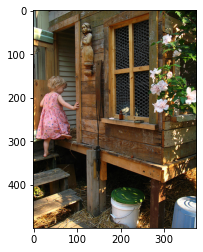

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [5]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [6]:
# create the vocabulary
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [7]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [8]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [9]:
# split into train and test sets
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [10]:
# add startseq and endseq to every caption
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [11]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [12]:
# only keep word which have been used ateast 10 times in the vocabulary
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [13]:
# map the words to numbers and vice-versa
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [14]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [15]:
# download the glove.6B.200.txt from link given in readme.md file
embeddings_index = {} 
f = open(os.path.join('glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [16]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)
# save the feature vectors in files so do not have to train the model again
df = pd.DataFrame.from_dict(encoding_train, orient ='index')
df.to_csv('train_image_features.txt', header=None, sep=' ', mode='a')
df1 = pd.DataFrame.from_dict(encoding_test, orient ='index')
df1.to_csv('test_image_features.txt', header=None, sep=' ', mode='a')

In [17]:
# load the previously trained feature vectors
# encoding_train = pd.read_csv('train_image_features.txt', header=None, sep=' ')
# encoding_train = encoding_train.set_index(0).T.to_dict('list')
# train_features = encoding_train

In [19]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332000      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
_______________________________________________________________________________________

In [20]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [21]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [22]:
epochs = 5
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/5
2000/2000 [==============================] - 3546s 2s/step - loss: 3.6884
Epoch 2/5
2000/2000 [==============================] - 3493s 2s/step - loss: 3.0348
Epoch 3/5
2000/2000 [==============================] - 3517s 2s/step - loss: 2.8347
Epoch 4/5
2000/2000 [==============================] - 3723s 2s/step - loss: 2.7171
Epoch 5/5
2000/2000 [==============================] - 3620s 2s/step - loss: 2.6304


In [23]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [35]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top n predictions and creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    #print(final_caption)
    return final_caption

In [25]:
#load the previously trained test set
# encoding_test = pd.read_csv('test_image_features.txt', header=None, sep=' ')
# encoding_test = encoding_test.set_index(0).T.to_dict('list')

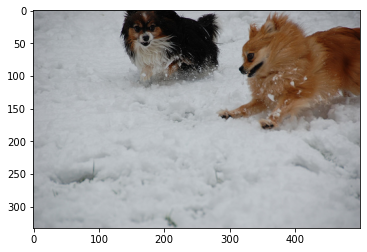

Greedy Search: a dog is running through the snow
a brown and white dog is running through the snow
Beam Search, K = 3: a brown and white dog is running through the snow
a brown and white dog is running through the snow
Beam Search, K = 5: a brown and white dog is running through the snow
a brown and white dog is running through the snow
Beam Search, K = 7: a brown and white dog is running through the snow
a brown and white dog with a stick in its mouth is running in the snow
Beam Search, K = 10: a brown and white dog with a stick in its mouth is running in the snow


In [33]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic]
image = np.array(image).reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
ans = greedySearch(image)
print(f'Greedy Search: {ans}')
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))

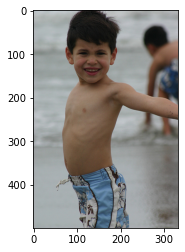

Greedy Search: a boy in a pink swimsuit is jumping into the water
a little boy in a pink bathing suit jumps into the water
Beam Search, K = 3: a little boy in a pink bathing suit jumps into the water


In [34]:
pic = list(encoding_test.keys())[1]
image = encoding_test[pic]
image = np.array(image).reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
ans = greedySearch(image)
print(f'Greedy Search: {ans}')
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))

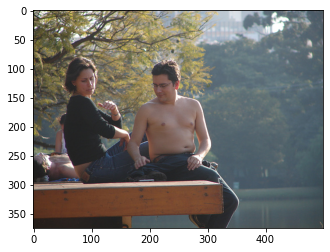

Greedy Search: a man in a white shirt is sitting on a bench next to a large tree
Beam Search, K = 3: a man is sitting on a bench next to a building
Beam Search, K = 5: a man sits on a bench next to a building
Beam Search, K = 7: a man sits on a bench next to a mountain


In [37]:
pic = list(encoding_test.keys())[2]
image = encoding_test[pic]
image = np.array(image).reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
ans = greedySearch(image)
print(f'Greedy Search: {ans}')
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))

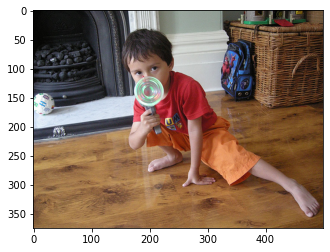

Greedy Search: a young boy is sitting on a bed
Beam Search, K = 3: a little boy in a red shirt is sitting on a bed
Beam Search, K = 5: a little boy in a red shirt is sitting on a bed next to a
Beam Search, K = 7: a little boy in a red shirt is playing with a toy


In [38]:
pic = list(encoding_test.keys())[4]
image = encoding_test[pic]
image = np.array(image).reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
ans = greedySearch(image)
print(f'Greedy Search: {ans}')
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))

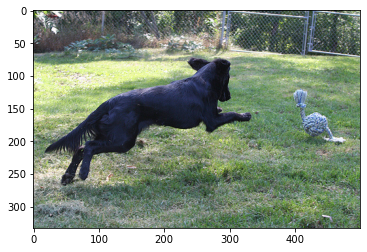

Greedy Search: a black dog is running through the grass
Beam Search, K = 3: a black dog is running through the grass
Beam Search, K = 5: a black dog runs through the grass
Beam Search, K = 7: a black dog runs through the grass


In [44]:
pic = list(encoding_test.keys())[5]
image = encoding_test[pic]
image = np.array(image).reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
ans = greedySearch(image)
print(f'Greedy Search: {ans}')
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))